## Email Spam Detection (Phase-2 Project-1) Data Science Internship

In [3]:
#import dependencies
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
#importing algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [5]:
db = pd.read_csv('spam.csv',encoding = "ISO-8859-1")

In [6]:
db.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
db.shape

(5572, 5)

In [8]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


# EDA

In [9]:
db.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [10]:
db.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
db.rename(columns={'v1':'result','v2':'text'},inplace=True)
db.head()

,result,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
label_encoder = LabelEncoder()
db['result'] = label_encoder.fit_transform(db.result)

In [13]:
db.head(3)

,result,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [14]:
db.isnull().sum()

result    0
text      0
dtype: int64

No null values are present

In [15]:
db.duplicated().sum()

403

Duplicates are present need to remove

In [16]:
db = db.drop_duplicates(keep='first')

In [17]:
db.shape

(5169, 2)

In [18]:
db['result'].value_counts()

0    4516
1     653
Name: result, dtype: int64

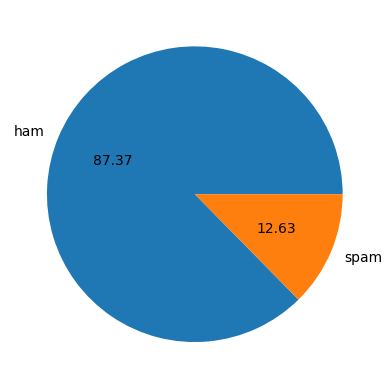

In [19]:
plt.pie(db['result'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

Highly imbalanced data

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Tokenizing the text

In [21]:
def processing(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    return text

In [22]:
db['processed_text'] = db['text'].apply(processing)

In [23]:
db.head(2)

,result,text,processed_text
0,0,"Go until jurong point, crazy.. Available only ...","[go, until, jurong, point, ,, crazy, .., avail..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, ..., joking, wif, u, oni, ...]"


Removing special characters

In [24]:
def p2(text):
  l = []
  for i in text:
    if i.isalnum:
      l.append(i)

  return l

In [25]:
db['processed_text'] = db['processed_text'].apply(p2)

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Removing stop words

In [27]:
from nltk.corpus import stopwords
import string
def remove_stop(text):
  l=[]
  for i in text:
    if i not in stopwords.words('english') and i not in string.punctuation:
      l.append(i)
  return l

In [28]:
db['processed_text'] = db['processed_text'].apply(remove_stop)

In [29]:
db['processed_text'].head()

0    [go, jurong, point, crazy, .., available, bugi...
1             [ok, lar, ..., joking, wif, u, oni, ...]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3    [u, dun, say, early, hor, ..., u, c, already, ...
4    [nah, n't, think, goes, usf, lives, around, th...
Name: processed_text, dtype: object

Stemming

In [30]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def stemm(text):
  l=[]
  for i in text:
    l.append(ps.stem(i))

  return " ".join(l)

In [31]:
db['processed_text'] = db['processed_text'].apply(stemm)

In [32]:
db['processed_text'].head()

0    go jurong point crazi .. avail bugi n great wo...
1                        ok lar ... joke wif u oni ...
2    free entri 2 wkli comp win fa cup final tkt 21...
3          u dun say earli hor ... u c alreadi say ...
4             nah n't think goe usf live around though
Name: processed_text, dtype: object

Vectorizing the text so that model can be trained

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tf = TfidfVectorizer()

In [34]:
X = cv.fit_transform(db['processed_text']).toarray()

In [35]:
y = db['result'].values

In [36]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=12)

In [38]:
classifier = GaussianNB()
classifier.fit(X_train,y_train)

GaussianNB()

In [39]:
X_test_pre = classifier.predict(X_test)
print(accuracy_score(X_test_pre,y_test))
print(confusion_matrix(X_test_pre,y_test))
print(precision_score(X_test_pre,y_test))

0.8820116054158608
[[798  12]
 [110 114]]
0.9047619047619048


In [40]:
models = [GaussianNB(), MultinomialNB(), BernoulliNB(), LogisticRegression(max_iter=1000,random_state=12),SVC(kernel='linear'),KNeighborsClassifier(),RandomForestClassifier(n_estimators=50, random_state=12)]

In [41]:
def ModelSelection(list_of_models):

    result=[]
    i=0

    for model in list_of_models:
        i+=1

        classifier = model
        classifier.fit(X_train,y_train)

        y_test_pre = classifier.predict(X_test)

        result.append({
            'model used':model,
            'accuracy score': accuracy_score(y_test_pre,y_test),
            'precision': precision_score(y_test_pre,y_test)
        })

    result_dataframe = pd.DataFrame(result, columns=['model used','accuracy score','precision'])

    return result_dataframe

Model Performance with count vectorized text

In [42]:
ModelSelection(models)

,model used,accuracy score,precision
0,GaussianNB(),0.882012,0.904762
1,MultinomialNB(),0.983559,0.960317
2,BernoulliNB(),0.981625,0.857143
3,"LogisticRegression(max_iter=1000, random_state...",0.983559,0.873016
4,SVC(kernel='linear'),0.987427,0.904762
5,KNeighborsClassifier(),0.914894,0.301587
6,"(DecisionTreeClassifier(max_features='sqrt', r...",0.975822,0.809524


In [43]:
X = tf.fit_transform(db['processed_text']).toarray()

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=2)

Model performance with tfidf vectorizer

In [45]:
ModelSelection(models)

,model used,accuracy score,precision
0,GaussianNB(),0.884913,0.862319
1,MultinomialNB(),0.962282,0.717391
2,BernoulliNB(),0.976789,0.847826
3,"LogisticRegression(max_iter=1000, random_state...",0.946809,0.608696
4,SVC(kernel='linear'),0.972921,0.826087
5,KNeighborsClassifier(),0.896518,0.224638
6,"(DecisionTreeClassifier(max_features='sqrt', r...",0.973888,0.804348


 **Model is performing well with countvectorization on Multinomial Naive Bayes**

In [46]:
X = cv.fit_transform(db['processed_text']).toarray()
y = db['result'].values

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=12)

In [48]:
classifier = MultinomialNB()
classifier.fit(X_train,y_train)

MultinomialNB()

In [49]:
X_test_pre = classifier.predict(X_test)
print(accuracy_score(X_test_pre,y_test))
print(confusion_matrix(X_test_pre,y_test))
print(precision_score(X_test_pre,y_test))

0.9835589941972921
[[896   5]
 [ 12 121]]
0.9603174603174603


<Axes: >

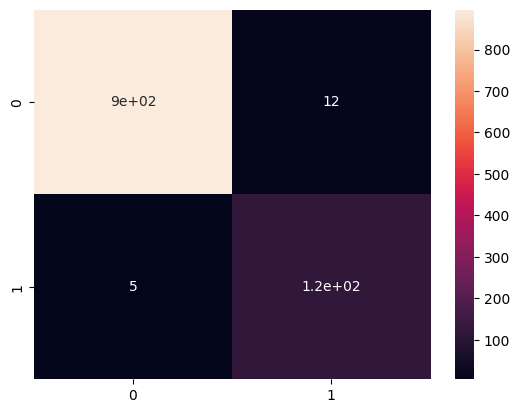

In [50]:
cf_matrix = confusion_matrix(y_test, X_test_pre)
sns.heatmap(cf_matrix,annot=True)

In [61]:
input_data = ("Offer click on the link")

input_data = processing(input_data)
input_data = p2(input_data)
input_data = remove_stop(input_data)
input_data = stemm(input_data)

# input_asnumpy_array = np.asarray(input_data)
# reshaped_input = input_asnumpy_array.reshape(1,-1)

print(input_data)

input_data = [input_data]

std_input = cv.transform(input_data).toarray()
print(std_input)

prediction = classifier.predict(std_input)
print(prediction)

offer click link
[[0 0 0 ... 0 0 0]]
[1]


**Hence the given text mail is a spam**